This notebook discusses `lmfit.ModelResult.eval_uncertainty()` and results from it.  It was sparked by a discussion at https://groups.google.com/g/lmfit-py/c/U0_zD3F9jw8/m/75P6TccSAQAJ  (Dec, 2023).


The code here uses the `eval_uncertainty_dscale` branch, which adds the optional scaling parameter `dscale` used to set the step size for derivatives calculated in `lmfit.Model.eval_uncertainty()`.

The `NIST_Gauss2.data` data file used here are from the `examples` folder in the lmfit source tree.  The values for the original question are included in the code. 

We'll start with a modified version of the original question.

In [1]:
# some basic imports
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model, models
from uncertainties import umath
%matplotlib inline

[[Model]]
    Model(expfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 25
    # variables        = 3
    chi-square         = 2.0705e-08
    reduced chi-square = 9.4115e-10
    Akaike info crit   = -516.793759
    Bayesian info crit = -513.137132
    R-squared          = 0.82814534
[[Variables]]
    offset:     6.9536e-05 +/- 1.6571e-05 (23.83%) (init = 0.0001)
    amplitude: -675692.422 +/- 5434521.95 (804.29%) (init = -9000)
    decay:     -22.2179797 +/- 8.14731073 (36.67%) (init = -20)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay)  = +0.9999
    C(offset, decay)     = +0.8711
    C(offset, amplitude) = +0.8671


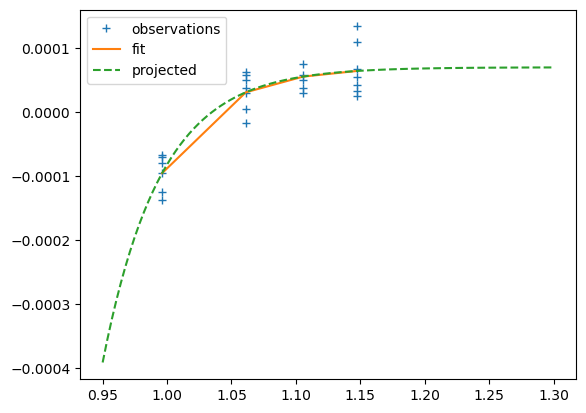

In [2]:
# Ries et al - hard clam data
# TA:DIC        Calc rate [mmol/g/hr] (compiled)
x = [1.147058824, 1.147058824, 1.147058824, 1.147058824, 1.147058824,
     1.147058824, 1.147058824, 1.105700713, 1.105700713, 1.105700713,
     1.105700713, 1.105700713, 1.061177816, 1.061177816, 1.061177816,
     1.061177816, 1.061177816, 1.061177816, 1.061177816, 0.996137132,
     0.996137132, 0.996137132, 0.996137132, 0.996137132, 0.996137132]

y = [0.00010823592100442932, 3.3303360309055184e-05, 0.00013321344123622074,
     6.660672061811037e-05, 4.162920038631898e-05, 5.411796050221466e-05,
     2.497752023179139e-05, 5.8280880540846574e-05, 4.995504046358278e-05,
     3.746628034768708e-05, 7.493256069537416e-05, 2.9140440270423287e-05,
     5.8280880540846574e-05, -1.6651680154527592e-05, 2.9140440270423287e-05,
     6.244380057947847e-05, 4.995504046358278e-05, 3.746628034768708e-05,
     4.162920038631898e-06, -9.574716088853365e-05, -0.00013737636127485265,
     -0.00012488760115895694, -6.660672061811037e-05, -7.909548073400604e-05,
     -7.076964065674227e-05]

def expfunc(x, offset, amplitude, decay):
    return offset + amplitude * np.exp(decay * x)

mod = Model(expfunc)
pars = mod.make_params(offset=1.e-4, amplitude=-9000, decay=-20)
result = mod.fit(y, pars, x=x)

print(result.fit_report())

plt.plot(x, y, '+', label='observations')
plt.plot(x, result.best_fit, '-', label='fit')

xpred = np.linspace(.95, 1.3, 100)
ypred = result.eval(x=xpred)

plt.plot(xpred, ypred, '--', label='projected')

plt.legend()
plt.show()

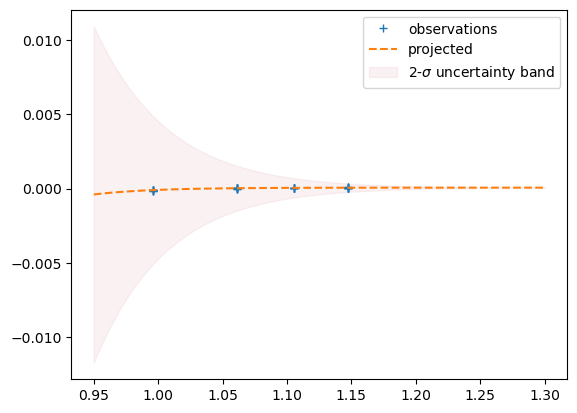

In [3]:
# now if we plot the predicted uncertainty

plt.plot(x, y, '+', label='observations')
plt.plot(xpred, ypred, '--', label='projected')

dypred = result.eval_uncertainty(x=xpred, sigma=2, dscale=0.333)

plt.fill_between(xpred, ypred-dypred, ypred+dypred,
                 color="#DD9DAB22", label=r'2-$\sigma$ uncertainty band')
plt.legend()

and the uncertainty looks enormous.   The basic quesstion is: Why?  The user showed results from Matlab that were much smaller. Why the difference?

In the lmfit 1.2.2, the value for `dscale` is fixed in the code to 0.33333.  
If we lower that, the result can change dramatically:


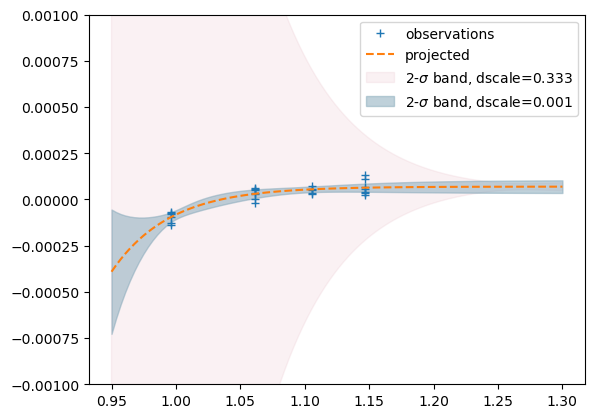

In [4]:
plt.plot(x, y, '+', label='observations')
plt.plot(xpred, ypred, '--', label='projected')

dypred_001 = result.eval_uncertainty(x=xpred, sigma=2, dscale=0.001)
plt.fill_between(xpred, ypred-dypred, ypred+dypred,
                 color="#DD9DAB22", label=r'2-$\sigma$ band, dscale=0.333')
plt.fill_between(xpred, ypred-dypred_001, ypred+dypred_001,
                 color="#88AABB88", label=r'2-$\sigma$ band, dscale=0.001')
plt.ylim((-0.001, 0.001))
plt.legend()

The uncertainties using dscale=0.001 appear to be much closer to the ones from Matlab.  This then is argued as being "correct".  

I have a concern with this though.  In that plot above, the gray band is meant to represent the 95% confidence level for the model / fit.  Not that below x=1.00, it never goes above 0: that is saying that one can be 95% confident that the value of model for x<1 is negative.

But the best fit value for the offset is definitely positive: 
    offset = 6.95e-05 +/- 1.67e-05  

The best fit value for the amplitude of the exponential is negative, but its 1-sigma uncertainty is 50x its best-fit value:  
    amplitude: -0.676e6 +/- 5.4e6 
    
That value is definitely consistent with 0.0.  It is barely negative.  The 2-sigma uncertainty for this term would be -1 +/- 100.   

How can then 95% confidence level for x<1 only include negative values? 


As a more-or-less independent check of confidence levels with Python, we can use the uncertainties package to propagate uncertainties from the correlated parameters, using its `umath` module which we imported above, and the `result.uvars` values, which are the `ufloats` (values with uncertainties that can be propagated) from the `uncertainties` package.   Note, however, that unlike `ModelResult.eval_uncertainty`, this takes into account only the reported uncertainties and correlations between fitted parameters.  It does not take into account the degrees of freedom in the fit.

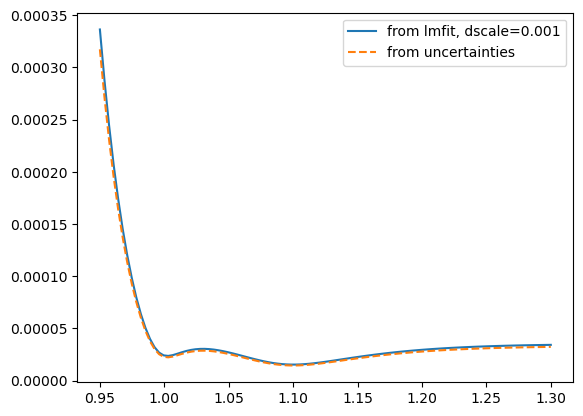

In [5]:
uvars = result.uvars
dy_umath = []
for _x in xpred:
    dy_umath.append((uvars['offset'] + uvars['amplitude'] * umath.exp(uvars['decay']*_x)).s)

# now we convert to an array and double it to get the 2-sigma confidence level
dy_umath = 2*np.array(dy_umath)

plt.plot(xpred, dypred_001, '-', label='from lmfit, dscale=0.001')
plt.plot(xpred, dy_umath, '--', label='from uncertainties')
plt.legend()
plt.show()


OK, those are very close, and appear to be very close to what Matlab gives. Again, apparently correct.. maybe.


But first, is using the default `dscale=0.333` always too big?  It turns out that it is not.  
Let's test that with a different dataset - the NIST Gauss2 dataset:

[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(exponential, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 250
    # variables        = 8
    chi-square         = 1247.52821
    reduced chi-square = 5.15507524
    Akaike info crit   = 417.864631
    Bayesian info crit = 446.036318
    R-squared          = 0.99648654
[[Variables]]
    g1_amplitude:   4257.77399 +/- 42.3838008 (1.00%) (init = 3000)
    g1_center:      107.030957 +/- 0.15006868 (0.14%) (init = 100)
    g1_sigma:       16.6725789 +/- 0.16048222 (0.96%) (init = 10)
    g2_amplitude:   2493.41715 +/- 36.1696228 (1.45%) (init = 3000)
    g2_center:      153.270104 +/- 0.19466723 (0.13%) (init = 150)
    g2_sigma:       13.8069453 +/- 0.18680099 (1.35%) (init = 10)
    bkg_amplitude:  99.0183280 +/- 0.53748639 (0.54%) (init = 100)
    bkg_decay:      90.9508824 +/- 1.10310769 (1.21%) (init = 80)
    g1_fwhm:       

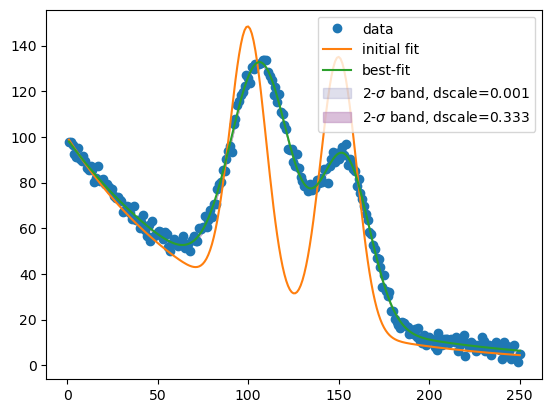

In [6]:
# load and set up fit for the NIST Gauss2 data
dat = np.loadtxt('NIST_Gauss2.dat')
xg = dat[:, 1]
yg = dat[:, 0]

nmodel = (models.GaussianModel(prefix='g1_') +
          models.GaussianModel(prefix='g2_') +
          models.ExponentialModel(prefix='bkg_'))

params = nmodel.make_params(bkg_amplitude=100, bkg_decay=80,
                            g1_amplitude=3000,
                            g1_center=100,
                            g1_sigma=10,
                            g2_amplitude=3000,
                            g2_center=150,
                            g2_sigma=10)

result = nmodel.fit(yg, params, x=xg)
print(result.fit_report(min_correl=0.5))

plt.plot(xg, yg, 'o', label='data')
plt.plot(xg, result.init_fit,  label='initial fit')
plt.plot(xg, result.best_fit, label='best-fit')


yg_dy333 = result.eval_uncertainty(sigma=2, dscale=0.333)
yg_dy001 = result.eval_uncertainty(sigma=2, dscale=0.001)

plt.fill_between(xg, result.best_fit-yg_dy001, result.best_fit-yg_dy001,
                 color="#8888BB44", label=r'2-$\sigma$ band, dscale=0.001')
                 
plt.fill_between(xg, result.best_fit-yg_dy333, result.best_fit-yg_dy333,
                 color="#BB88BB88", label=r'2-$\sigma$ band, dscale=0.333')

plt.legend()

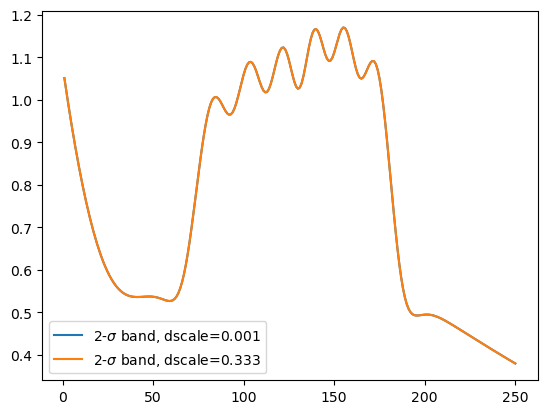

In [7]:
# those uncertainty bands are too small and too close to tell apart, so let's plot just them:

plt.plot(xg, yg_dy001,  label=r'2-$\sigma$ band, dscale=0.001')
plt.plot(xg, yg_dy333,  label=r'2-$\sigma$ band, dscale=0.333')
plt.legend()


those uncertainties are right on top of each other.  So `dscale=0.333` is not always wrong!

OK, well, maybe that's an easier case. Let's try a different exponential decaying data set:

[[Model]]
    Model(expfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 21
    # variables        = 3
    chi-square         = 3.6944e-04
    reduced chi-square = 2.0524e-05
    Akaike info crit   = -223.909014
    Bayesian info crit = -220.775447
    R-squared          = 0.99982908
[[Variables]]
    offset:    -0.49805969 +/- 0.00344877 (0.69%) (init = -0.1)
    amplitude:  2.86110664 +/- 0.02355887 (0.82%) (init = 0.2)
    decay:     -0.30064521 +/- 0.00281076 (0.93%) (init = -0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay)  = -0.9273
    C(offset, decay)     = -0.8961
    C(offset, amplitude) = +0.7041


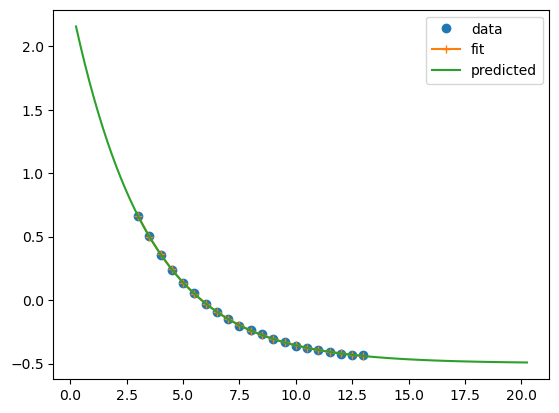

In [8]:

xx = np.linspace(3, 13, 21)
yy = -0.5  + 2.85 * np.exp(-0.3*xx) + np.random.normal(size=len(xx), scale=0.005)

mod = Model(expfunc)
pars = mod.make_params(offset=-0.1, amplitude=0.2, decay=-0.1)
result = mod.fit(yy, pars, x=xx)

print(result.fit_report())

plt.plot(xx, yy, 'o', label='data')
plt.plot(xx, result.best_fit, '+-', label='fit')

xpred = np.linspace(.25, 20.25, 101)
ypred = result.eval(x=xpred)

plt.plot(xpred, ypred, label='predicted')
plt.legend()

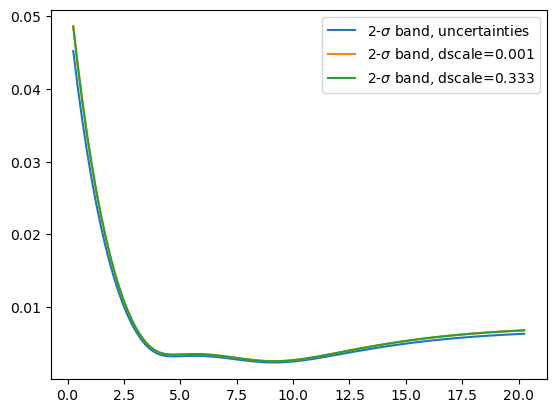

In [9]:

dy_dscale001 = result.eval_uncertainty(x=xpred, sigma=2, dscale=0.001)

dy_dscale333 = result.eval_uncertainty(x=xpred, sigma=2, dscale=0.333)

# and compare with uncertainties package
u = result.uvars
dy_umath = []
for ox in xpred:
    ux = u['offset'] + u['amplitude'] * umath.exp(u['decay']*ox)
    dy_umath.append(ux.s)
dy_umath = 2*np.array(dy_umath)


plt.plot(xpred, dy_umath, label=r'2-$\sigma$ band, uncertainties')
plt.plot(xpred, dy_dscale001, label=r'2-$\sigma$ band, dscale=0.001')
plt.plot(xpred, dy_dscale333, label=r'2-$\sigma$ band, dscale=0.333')
plt.legend()

...also very, very close.


Let's go back to that original data.  It presents as 25 data "observations", but really has 4 independent x values for the model to be evaluated at.  This might be expressed as

<ErrorbarContainer object of 3 artists>

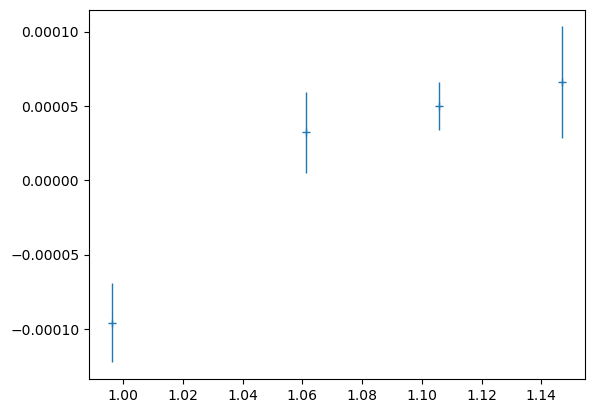

In [10]:
x = np.array([1.147058824, 1.105700713, 1.061177816, 0.996137132])
y = np.array([6.6012e-05,  4.9955e-05, 3.2114e-05, -9.5747e-05])
dy = np.array([3.7395e-05, 1.6015e-05, 2.7044e-05, 2.6871e-05])

plt.errorbar(x, y, yerr=dy, linewidth=0., elinewidth=1, marker='+', label='data')
    

[[Model]]
    Model(expfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 187
    # data points      = 4
    # variables        = 3
    chi-square         = 0.05494179
    reduced chi-square = 0.05494179
    Akaike info crit   = -11.1511016
    Bayesian info crit = -12.9922185
    R-squared          = 0.99662934
[[Variables]]
    offset:     6.3505e-05 +/- 8.8375e-06 (13.92%) (init = 0.0001)
    amplitude: -3523190.54 +/- 18920125.7 (537.02%) (init = -9000)
    decay:     -23.9132155 +/- 5.43632420 (22.73%) (init = -20)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, decay)  = +1.0000
    C(offset, decay)     = +0.9222
    C(offset, amplitude) = +0.9201


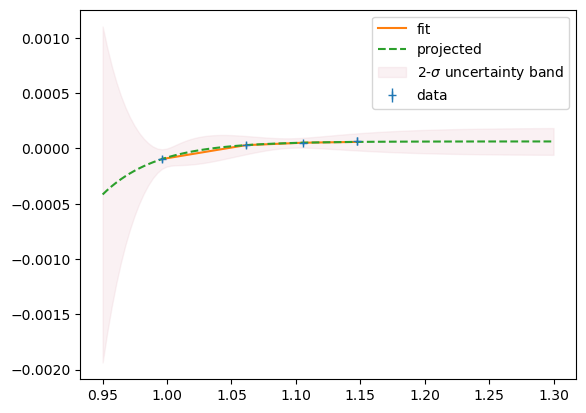

In [11]:
# and now we can try to fit that using 4 values with uncertainties:

mod = Model(expfunc)
pars = mod.make_params(offset=1.e-4, amplitude=-9000, decay=-20)
result = mod.fit(y, pars, x=x, weights=1.0/dy)

print(result.fit_report())

plt.errorbar(x, y, yerr=dy, linewidth=0., elinewidth=1, marker='+', label='data')
plt.plot(x, result.best_fit, '-', label='fit')

xpred = np.linspace(.95, 1.3, 100)
ypred = result.eval(x=xpred)

plt.plot(xpred, ypred, '--', label='projected')

dypred = result.eval_uncertainty(x=xpred, sigma=2, dscale=0.001)

plt.fill_between(xpred, ypred-dypred, ypred+dypred,
                 color="#DD9DAB22", label=r'2-$\sigma$ uncertainty band')
plt.legend()

now, with only one degree of freedom. The fit more clearly shows the extremely high correlations.  It is more obvious that the uncertainties are extremely large for the extrapolated values.  The plot here also makes it clearer that the amplitude term can be positive.    


My conclusions here are:  

   1. we should lower the default step for the derivative in `ModelResult.eval_uncertainty` to 0.001 for more stability, especially for pathological cases like this one.
   2. extrapolating uncertainties outside the range of the actual data should be viewed with caution.
   3. estimates of uncertainties should be viewed with caution when the degrees of freedom in a fit is very low.